In [11]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from numpy.random import normal
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")
import os



def one_hot_encode(train_data, test_data, columns):
    '''Returns a DataFrame with encoded columns'''
    conc = pd.concat([train_data, test_data], axis=0)
    encoded_cols = []
    for col in columns:
        encoded_cols.append(pd.get_dummies(conc[col], prefix='one_hot_'+col, 
                                      drop_first=True))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.iloc[: train_data.shape[0], :],
    
            all_encoded.iloc[train_data.shape[0]:,:])


def one_hot_encode(train_data, test_data, columns):
    conc = pd.concat([train_data, test_data], axis=0)
    encoded = pd.get_dummies(conc.loc[:, columns], drop_first=True,
                             sparse=True) 
    return (encoded.iloc[:train_data.shape[0],:], 
            encoded.iloc[train_data.shape[0]:,:])


def label_encode(train_data, test_data, columns):
    'Returns a DataFrame with encoded columns'
    encoded_cols = []
    for col in columns:
        factorised = pd.factorize(train_data[col])[1]
        labels = pd.Series(range(len(factorised)), index=factorised)
        encoded_col_train = train_data[col].map(labels) 
        encoded_col_test = test_data[col].map(labels)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = -1
        encoded_cols.append(pd.DataFrame({'label_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def freq_encode(train_data, test_data, columns):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    nsamples = train_data.shape[0]
    for col in columns:    
        freqs_cat = train_data.groupby(col)[col].count()/nsamples
        encoded_col_train = train_data[col].map(freqs_cat)
        encoded_col_test = test_data[col].map(freqs_cat)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = 0
        encoded_cols.append(pd.DataFrame({'freq_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=0, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            kfold = StratifiedKFold( folds, shuffle=True, random_state=1)
            parts = []
            for tr_in, val_ind in kfold.split( train_data.drop([target_col],axis = 1).values , train_data[target_col].values ):
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def test_clf(X_train, y_train, X_test, y_test, iterations):
    train_scores = []
    val_scores = []
    for i in iterations:
        model = GradientBoostingRegressor(n_estimators=i, learning_rate=1, max_depth=3, 
                                           min_samples_leaf=3, random_state=0)
        model.fit(X_train, y_train)
        y_train_pred_scores = model.predict(X_train)
        y_test_pred_scores = model.predict(X_test)
        train_scores.append(mean_absolute_error(y_train, y_train_pred_scores))
        val_scores.append(mean_absolute_error(y_test, y_test_pred_scores))
    return train_scores, val_scores

def test_reg(X_train, y_train, X_test, y_test, iterations):
    train_scores = []
    val_scores = []
    for i in n_estimators_list:   
        model = GradientBoostingClassifier(n_estimators=i, learning_rate=1, max_depth=3, 
                                           min_samples_leaf=3, random_state=0, max_features=max_features)
        model.fit(X_train, y_train)
        y_train_pred_scores = model.predict_proba(X_clf_train)[:,1]
        y_test_pred_scores = model.predict_proba(X_clf_test)[:,1]
        train_scores.append(roc_auc_score(y_clf_train, y_train_pred_scores))
        val_scores.append(roc_auc_score(y_clf_test, y_test_pred_scores))
    return train_scores, val_scores

def scoring_gbr_sklern(X_train, y_train, X_test, y_test, n_estimators=100, 
                       learning_rate=1, max_depth=3, random_state=0, max_features=None,
                       min_samples_leaf=1, verbose=False):
    scores_train = []
    scores_test = []
    iterations = []
    log_iters = list(set((np.logspace(math.log(1, 8), math.log(400, 8), 
                                      num=50, endpoint=True, base=8, 
                                      dtype=np.int))))
    log_iters.sort()
    for i in log_iters:
        model = GradientBoostingRegressor(n_estimators=i, learning_rate=learning_rate, 
                                          max_depth=max_depth, random_state=random_state,
                                          min_samples_leaf=min_samples_leaf, max_features=max_features)
        model.fit(X_train, y_train)
        y_train_pred_scores = model.predict(X_train)
        y_test_pred_scores = model.predict(X_test)
        scores_train.append(mean_squared_error(y_train, y_train_pred_scores))
        scores_test.append(mean_squared_error(y_test, y_test_pred_scores))
        iterations.append(i)
        if verbose:
            print(i, scores_train[-1], scores_test[-1])
    best_score = min(scores_test)
    best_iter = iterations[scores_test.index(best_score)]
    if verbose:
        print('Best score: {}\nBest iter: {}'.format(best_score, best_iter))
    return scores_train, scores_test, iterations, model

def scoring_gbc_sklern(X_train, y_train, X_test, y_test, n_estimators=100, 
                       learning_rate=1, max_depth=3, random_state=0, max_features=None,
                       min_samples_leaf=1, verbose=False):
    scores_train = []
    scores_test = []
    iterations = []
    weight_0 = 1
    weight_1 = (len(y_train) - y_train.sum())/y_train.sum()
    sample_weights = [weight_1 if i else weight_0 for i in y_train]
    log_iters = list(set((np.logspace(math.log(1, 8), math.log(500, 8), 
                                      num=50, endpoint=True, base=8, 
                                      dtype=np.int))))
    log_iters.sort()
    for i in log_iters:
        model = GradientBoostingClassifier(n_estimators=i, learning_rate=learning_rate, 
                                          max_depth=max_depth, random_state=random_state,
                                          min_samples_leaf=min_samples_leaf, max_features=max_features)
        model.fit(X_train, y_train, sample_weight=sample_weights)
        y_train_pred_scores = model.predict_proba(X_train)
        y_test_pred_scores = model.predict_proba(X_test)
        scores_train.append(roc_auc_score(y_train, y_train_pred_scores[:,1]))
        scores_test.append(roc_auc_score(y_test, y_test_pred_scores[:,1]))
        iterations.append(i)
        if verbose:
            print(iterations[-1], scores_train[-1], scores_test[-1])
    best_score = max(scores_test)
    best_iter = iterations[scores_test.index(best_score)]
    if verbose:
        print('Best score: {}\nBest iter: {}'.format(best_score, best_iter))
    return scores_train, scores_test, iterations, model

def test_encoding(train_data, test_data, cols_to_encode, target_col, encoding_funcs, 
                  scoring_func, scoring_func_params={}, other_cols_to_use=None,
                  alpha=0):
    y_train = train_data[target_col]
    y_test = test_data[target_col]
    X_train_cols = []
    X_test_cols = []
    for encoding_func in encoding_funcs:  
        if (encoding_func==mean_encode) or (encoding_func==mean_and_freq_encode):
            encoded_features = encoding_func(train_data, test_data, cols_to_encode, 
                                             target_col=target_col, alpha=alpha)
        else:
            encoded_features = encoding_func(train_data, test_data, cols_to_encode)
        X_train_cols.append(encoded_features[0]), 
        X_test_cols.append(encoded_features[1])
    X_train = pd.concat(X_train_cols, axis=1)
    X_test = pd.concat(X_test_cols, axis=1)
    if other_cols_to_use:
        X_train = pd.concat([X_train, train_data.loc[:, other_cols_to_use]], axis=1)
        X_test = pd.concat([X_test, test_data.loc[:, other_cols_to_use]], axis=1)
    return scoring_func(X_train, y_train, X_test, y_test, **scoring_func_params)

def describe_dataset(data, target_col):
    ncats = []
    ncats10 = []
    ncats100 = []
    nsamples_median = []
    X_col_names = list(data.columns)
    X_col_names.remove(target_col)
    print('Number of samples: ', data.shape[0])
    for col in X_col_names:
        counts = data.groupby([col])[col].count()
        ncats.append(len(counts))
        ncats10.append(len(counts[counts<10]))
        ncats100.append(len(counts[counts<100]))
        nsamples_median.append(counts.median())
    data_review_df = pd.DataFrame({'Column':X_col_names, 'Number of categories':ncats, 
                                   'Categories with < 10 samples':ncats10,
                                   'Categories with < 100 samples':ncats100,
                                   'Median samples in category':nsamples_median})
    data_review_df = data_review_df.loc[:, ['Column', 'Number of categories',
                                             'Median samples in category',
                                             'Categories with < 10 samples',
                                             'Categories with < 100 samples']]
    return data_review_df.sort_values(by=['Number of categories'], ascending=False)

def make_movie():
    movie = pd.read_csv('../input/IMDB-Movie-Data1.csv').loc[:, ['Genre', 'Year', 'Rating', 
                                                       'Revenue (Millions)']]
    movie = movie.loc[movie['Revenue (Millions)'].notnull(), :]
    movie['Year x Rating'] = movie['Year'] + movie['Rating']
    return movie

def encoding_stats(train_data, test_data, X_train, X_test, target_col, encoding_function,
                  feature_cols_to_use):
    if encoding_function.__name__ == 'one_hot_encode':
        return np.nan, np.nan, np.nan, np.nan
    if encoding_function.__name__ == 'mean_encode':
        enc_suffix = 'mean_'+target_col+'_'
    if encoding_function.__name__ == 'freq_encode':    
        enc_suffix = 'freq_'
    if encoding_function.__name__ == 'label_encode':
        enc_suffix = 'label_'
    cols_to_encoded_mapping = {}
    for col in feature_cols_to_use:
        for col_enc in X_train.columns:
            if col == col_enc[len(enc_suffix):]:
                cols_to_encoded_mapping[col] = col_enc
    train_conc = pd.concat([train_data, X_train], axis=1)
    test_conc = pd.concat([test_data, X_test], axis=1)
    mean_stds_train = []
    std_means_train = []
    mean_stds_test = []
    std_means_test = []
    for key in cols_to_encoded_mapping.keys():
        #how much randomisation added
        mean_stds_train.append(train_conc.groupby(key)[cols_to_encoded_mapping[key]].std().mean())
        mean_stds_test.append(test_conc.groupby(key)[cols_to_encoded_mapping[key]].std().mean())
        # how distinguishable are categories with that encoding
        std_means_train.append(train_conc.groupby(key)[cols_to_encoded_mapping[key]].mean().std())
        std_means_test.append(test_conc.groupby(key)[cols_to_encoded_mapping[key]].mean().std())
    
    encoding_stats = (np.mean(mean_stds_train), np.mean(std_means_train),
                      np.mean(mean_stds_test), np.mean(std_means_test))
    return encoding_stats

def test_all_encodings(train_data, test_data, target_col, testing_params, 
                       test_one_hot=False, regression=False, skip_first_iters_graph=0,
                      max_features_one_hot=0.01):
    encoding_settings = [[label_encode, {}, 'Label encoding', '#960000'],
                         [freq_encode, {}, 'Frequency encoding', '#FF2F02'],
                         [mean_encode, {'alpha':0, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col},
                         'Mean encoding, alpha=0', '#A4C400'],
                         [mean_encode, {'alpha':2, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=2', '#73B100'],
                         [mean_encode, {'alpha':5, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5', '#2B8E00'],
                         [mean_encode, {'alpha':5, 'folds':3, 'reg_method':'k_fold', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, 4 folds', '#00F5F2'],
                         [mean_encode, {'alpha':5, 'folds':5, 'reg_method':'k_fold', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, 7 folds', '#00BAD3'],
                         [mean_encode, {'alpha':5, 'folds':None, 'reg_method':'expanding_mean', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, expanding mean', '#B22BFA']]
    review_rows = []
    if test_one_hot:
        oh_settings = [[one_hot_encode, {}, 'One hot encoding', '#E7E005']]
        encoding_settings = oh_settings + encoding_settings
    feature_cols_to_use = list(train_data.columns)
    feature_cols_to_use.remove(target_col)
    if regression:
        scoring_function = scoring_gbr_sklern
        best_score_function = min
    else:
        scoring_function = scoring_gbc_sklern
        best_score_function = max     
    plt.figure(figsize=(10,7))
    for encoding_function, encoding_params, str_name, color in encoding_settings:
        if encoding_function.__name__ == 'one_hot_encode':
            testing_params['max_features'] = max_features_one_hot
        else:
            testing_params['max_features'] = None
        X_train, X_test = encoding_function(train_data, test_data, feature_cols_to_use,
                                            **encoding_params)
        scores = scoring_function(X_train, train_data[target_col], X_test, 
                                    test_data[target_col], 
                                    min_samples_leaf=1, max_depth=3, **testing_params)
        skip_it = int(skip_first_iters_graph)
        train_scores, test_scores, iters, model_ = scores
        plt.plot(iters[skip_it:], 
                 test_scores[skip_it:], 
                 label='Test, ' + str_name, linewidth=1.5, color=color)
        best_score_test = best_score_function(test_scores)
        best_iter_test = iters[test_scores.index(best_score_test)]
        best_score_train = best_score_function(train_scores[:best_iter_test])
        print('Best score for {}: is {}, on iteration {}'.format(str_name, 
                                                                 best_score_test, 
                                                                 best_iter_test,
                                                                 best_score_train))
        enc_stats = encoding_stats(train_data, test_data, X_train, X_test, 
                                   target_col, encoding_function, feature_cols_to_use)
        review_rows.append([str_name, best_score_train, best_score_test, best_iter_test] + list(enc_stats))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if regression:
        columns=['Encoding', 'Train RMSE score on best iteration', 
             'Best RMSE score (test)', 'Best iteration (test)',
             'EV (train)', 'ED (train)', 'EV (test)', 'ED (test)']
    else:
        columns=['Encoding', 'Train AUC score on best iteration', 
             'Best AUC score (test)', 'Best iteration (test)',
             'EV (train)', 'ED (train)', 'EV (test)', 'ED (test)']
    return pd.DataFrame(review_rows, columns=columns)

Number of samples:  872
Best score for One hot encoding: is 7580.875794455195, on iteration 245
Best score for Label encoding: is 8257.421388620522, on iteration 63
Best score for Frequency encoding: is 9457.710408935138, on iteration 16
Best score for Mean encoding, alpha=0: is 8208.086676959303, on iteration 6
Best score for Mean encoding, alpha=2: is 8114.568710922977, on iteration 5
Best score for Mean encoding, alpha=5: is 8310.804958449018, on iteration 6


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

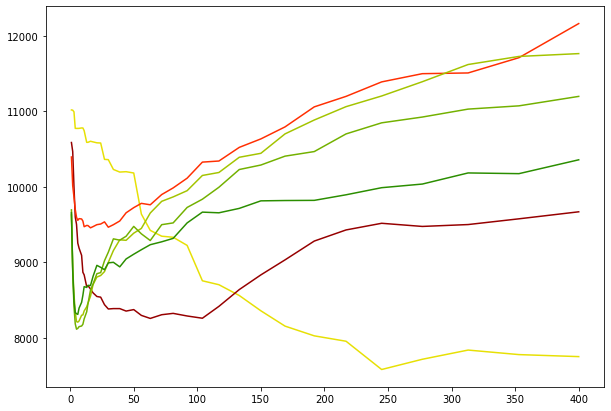

In [12]:

movie = make_movie()
target_col = 'Revenue (Millions)'
describe_dataset(movie, target_col)

train_data, test_data = train_test_split(movie, test_size=0.3, random_state=4)
testing_params = {'learning_rate':0.2}

test_all_encodings(train_data, test_data, target_col, testing_params, 
               test_one_hot=True, regression=True)

In [8]:
train_data

,Genre,Year,Rating,Revenue (Millions),Year x Rating
689,"Drama,Mystery,Thriller",2011,7.1,24.10,2018.1
850,"Crime,Drama,Thriller",2008,6.8,81.16,2014.8
341,"Action,Crime,Drama",2012,7.4,66.47,2019.4
238,"Adventure,Comedy,Drama",2014,8.1,59.07,2022.1
948,"Action,Adventure,Sci-Fi",2013,4.9,60.52,2017.9
...,...,...,...,...,...
400,"Animation,Action,Adventure",2015,6.4,336.03,2021.4
804,"Fantasy,Horror",2007,6.8,71.98,2013.8
491,"Action,Adventure,Drama",2010,6.9,94.82,2016.9
194,"Action,Drama,Sport",2011,8.2,13.65,2019.2
